# Post-processing of case studies

## Usage notes

All figures will be written to the directory `img` as pdf and png files.

It will look for results in a "simulation/<simulator>" folder on the same level as this notebook. Simulators currently supported: "dymola", "optimica"

## Import required libraries

In [1]:
import os
import cases

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plotter

## Load in simulation results

In [5]:
# Helper methods

def get_results(case_name, simulator = "dymola"):
    """ Get the results for the case with name `case_name`
    from a "simulation/<simulator>" folder.

    Parameters:
    
        simulator: str
            "optimica" or "dymola"

    Returns:

        Reader: buildingspy.io.outputpy.Reader instance
    """
    if simulator not in ["dymola", "optimica"]:
        raise Exception("Unsupported simulator provided.")

    # First make sure that the simulation was successful

    # For results generated using Dymola
    if simulator == "dymola":

        dslog_name = os.path.join("simulations", simulator, case_name, "dslog.txt")
        with open(dslog_name) as dslog:
            if not "Integration terminated successfully" in dslog.read():
                raise Exception("Simulation failed. Check {}".format(dslog_name))

    # For results generated using Optimica
    elif simulator == "optimica":

        for file in os.listdir(os.path.join("simulations", simulator, case_name)):
            if '.json' in file:
                json_log_fullpath = os.path.join("simulations", simulator, case_name, file)
                import json
                if not json.load(open(json_log_fullpath))["translation"]["success"]:
                    raise Exception("Simulation failed. Check {}".format(json_log_fullpath))
    
    else:
        raise Exception("Simulation log found for neither supported simulation engine.")

    file_name = cases.get_result_fullpath(case_name, simulator)

    return Reader(file_name, simulator)


def get_partial_results(case_name, list_of_variables, simulator = "dymola", 
                        as_dataframe = False, equidistant = False):
    """ Get a dictionary with the variable names and the time series for `list_of_variables`

    Parameters:
    
        case_name: str
            Name of the simulated case

        list_of_variables: list
            Variable names for which to extract the result data

        simulator: str
            "optimica" or "dymola" 

        as_dataframe: bool
            If all variables have the same time record in the output one may convert the 
            resulting dictionary into a dataframe
            
        equidistant: bool
            Adds a column with the timestep size, if the results are with
            an equidistant timestep (no events).

    Returns:

        d: dataframe or dict
            holds time and varable for each variable listed in list_of_variables
    """
    reader = get_results(case_name, simulator = simulator)
    d = dict()
    for v in list_of_variables:
        d['time_' + v] = reader.values(v)[0]
        d[v] = reader.values(v)[1]

    if as_dataframe:
        import pandas as pd
        d = pd.DataFrame(d)
        if equidistant:
            d['ts_duration_min'] = pd.Series(
                d['time_' + list_of_variables[0]][1:].values - d[
                    'time_' + list_of_variables[0]][:-1].values).unique()[0]/60

    return d

In [6]:
# Read in all simulation results

all_case_names = cases.get_list_of_case_names()
print("Found cases:", all_case_names)

res = {"optimica" : dict(), "dymola" : dict()}

simulators = ["dymola", "optimica"]
for simulator in simulators:
    for case_name in all_case_names:
        res[simulator][case_name] = get_results(case_name, simulator)

print("Read in simulation results.")

Found cases: ['base_summer', '1711_cwreset_summer', '1711_wse_summer', '1711_cwreset_wse_summer', 'base_annual', '1711_cwreset_annual', '1711_wse_annual', '1711_cwreset_wse_annual']
Read in simulation results.


## Explore variables found in the simulation results

In [7]:
# aggregate data timeseries

PAgg = {"dymola": dict(), "optimica": dict()}
simulators = ["dymola", "optimica"]
for simulator in simulators:
    for case in all_case_names:
        PAgg[simulator][case] = get_partial_results(
            case,  ["PConWatPumAgg.y", "PChiWatPumAgg.y", "PChiAgg.y", "PCooTowAgg.y", "PSupFanAgg.y","QRooIntGaiAgg.y"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        PAgg[simulator][case] = PAgg[simulator][case].loc[(PAgg[simulator][case].index % 2)==0,:].reset_index(drop=True)

In [8]:
PAgg["dymola"]['base_annual'].head(10)
PAgg["dymola"]['1711_wse_annual'].head(10)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,48.666667
1,5840.0,87946184.0,5840.0,1.305776e+06,5840.0,0.0,5840.0,35040000.0,5840.0,2.479034e+08,5840.0,2.368461e+08,48.666667
2,11680.0,175892368.0,11680.0,2.611186e+06,11680.0,0.0,11680.0,70080000.0,11680.0,4.958067e+08,11680.0,9.473794e+08,48.666667
3,17520.0,263838544.0,17520.0,3.916596e+06,17520.0,0.0,17520.0,105120000.0,17520.0,7.437101e+08,17520.0,2.131602e+09,48.666667
4,23360.0,351784736.0,23360.0,5.355852e+06,23360.0,0.0,23360.0,140160000.0,23360.0,9.916134e+08,23360.0,3.789513e+09,48.666667
5,29200.0,439730912.0,29200.0,8.125274e+06,29200.0,0.0,29200.0,175200000.0,29200.0,1.239517e+09,29200.0,5.921113e+09,48.666667
6,35040.0,527677088.0,35040.0,1.331449e+07,35040.0,0.0,35040.0,210240000.0,35040.0,1.487420e+09,35040.0,8.526402e+09,48.666667
7,40880.0,615623296.0,40880.0,2.161022e+07,40880.0,0.0,40880.0,245280000.0,40880.0,1.735324e+09,40880.0,1.144000e+10,48.666667
8,46720.0,703569472.0,46720.0,3.174388e+07,46720.0,0.0,46720.0,280320000.0,46720.0,1.983227e+09,46720.0,1.436000e+10,48.666667
9,52560.0,791515648.0,52560.0,4.290219e+07,52560.0,0.0,52560.0,315360000.0,52560.0,2.231130e+09,52560.0,1.728000e+10,48.666667


In [9]:
data = {"dymola": dict(), "optimica": dict()}
simulators = ["dymola", "optimica"]

for simulator in simulators:
    
    for case in all_case_names:
        if "1711_cwreset_" in case and "_wse_" not in case: 
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.eta", "pumCW.y", "pumCW.P", "TAirSup.T", "chi.on", "waterSideEconomizerOnOff.yOn"]
        elif "_wse_" in case:
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.eta","pumCW.P","TAirSup.T", "chi.on", "yWSEOn.y"]
        else:
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.P", "pumCW.eta","TAirSup.T", "chi.on", "waterSideEconomizerOnOff.yOn"]
            
        if "1711_cwreset_" in case:
            var_labels += ["pumCW.y"]
            
        data[simulator][case] = get_partial_results(
            case,  var_labels, simulator, as_dataframe=True)
        
        data[simulator][case] = data[simulator][case].loc[(data[simulator][case].index % 2)==0,:].reset_index(drop=True)
        
data["dymola"]['1711_cwreset_wse_annual'].columns

Index(['time_weaBus.TWetBul', 'weaBus.TWetBul', 'time_pumCW.m_flow',
       'pumCW.m_flow', 'time_chilledWaterReset.uChiWatPlaRes',
       'chilledWaterReset.uChiWatPlaRes',
       'time_chilledWaterReset.TChiWatSupSet',
       'chilledWaterReset.TChiWatSupSet',
       'time_chilledWaterReset.dpChiWatPumSet',
       'chilledWaterReset.dpChiWatPumSet', 'time_pumCW.VMachine_flow',
       'pumCW.VMachine_flow', 'time_pumCW.eta', 'pumCW.eta', 'time_pumCW.P',
       'pumCW.P', 'time_TAirSup.T', 'TAirSup.T', 'time_chi.on', 'chi.on',
       'time_yWSEOn.y', 'yWSEOn.y', 'time_pumCW.y', 'pumCW.y'],
      dtype='object')

### Some statistics

In [10]:
# to add months to equidistant data

df = data["dymola"]['base_annual']
df['12 bins'] = list(df.index/(5401/12))
df['12 bins'] = np.ceil(df['12 bins'])

count_wse_on_per_month = df.groupby('12 bins').sum()["waterSideEconomizerOnOff.yOn"].reset_index()

# df.index

# list(df.index/12)

# base_annual = df[df["chi.on"] != 1.][df["waterSideEconomizerOnOff.yOn"] == 1.]
df1 = data["dymola"]['1711_wse_annual']
# wse_annual = df1[df1["chi.on"] != 1.][df1["yWSEOn.y"] == 1.]
# df2 = data["dymola"]['1711_cwreset_wse_annual']
# cwreset_wse_annual = df2[df2["chi.on"] != 1.][df2["yWSEOn.y"] == 1.]

# print(base_annual.shape)
# print(wse_annual.shape)
# print(cwreset_wse_annual.shape)

count_wse_on_per_month
df1["yWSEOn.y"].sum()

2004.0

In [11]:
pd.options.display.float_format = '{:,.2f}'.format

data1 = data.copy()

for case in all_case_names:
    data1["dymola"][case] = data["dymola"][case][data["dymola"][case].columns.drop(list(data["dymola"][case].filter(regex='time_')))]

for case in all_case_names:
    print("\n {case_name}, simulation averages: \n".format(case_name = case))

    print(data1["dymola"][case].mean())
    print("\nChiller ON % of time", data1["dymola"][case].mean()["chi.on"])
    try:
        print("WSE ON % of time", data1["dymola"][case].mean()["waterSideEconomizerOnOff.yOn"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"].sum() - sum(data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"] == data1["dymola"][case].loc[:, "chi.on"]))
    except:
        print("WSE ON % of time", data1["dymola"][case].mean()["yWSEOn.y"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "yWSEOn.y"].sum() - sum(data1["dymola"][case].loc[
            :, "yWSEOn.y"] == data1["dymola"][case].loc[:, "chi.on"]))


 base_summer, simulation averages: 

weaBus.TWetBul                         288.99
pumCW.m_flow                            39.68
chilledWaterReset.uChiWatPlaRes          0.82
chilledWaterReset.TChiWatSupSet        284.73
chilledWaterReset.dpChiWatPumSet   129,684.64
pumCW.VMachine_flow                      0.04
pumCW.P                             10,449.57
pumCW.eta                                0.49
TAirSup.T                              294.13
chi.on                                   1.00
waterSideEconomizerOnOff.yOn             0.99
dtype: float32

Chiller ON % of time 0.99981487
WSE ON % of time 0.99370486
Data records where WSE is on and chiller is not: -1.0

 1711_cwreset_summer, simulation averages: 

weaBus.TWetBul                         288.99
pumCW.m_flow                            40.02
chilledWaterReset.uChiWatPlaRes          0.82
chilledWaterReset.TChiWatSupSet        284.73
chilledWaterReset.dpChiWatPumSet   129,684.64
pumCW.VMachine_flow                      0.04
pumC

# Compile total energy use per device, case, and simulator

## Energy use

We obtain the energy use as cumulative power consumed by:

- Zone supply fan: fan.P
- Chilled water pump: pumCHW.P
- Condenser water pump: pumCW.P
- Chiller: chi.P
- Cooling tower: cooTow.PFan

We also look at the aggregate IT Heat Load

In [12]:
vlmap = {
    "PConWatPumAgg.y" : "CW Pump [kWh]",
    "PChiWatPumAgg.y" : "CHW Pump [kWh]",
    "PChiAgg.y" : "Chiller [kWh]",
    "PCooTowAgg.y" : "Cooling Tower Fan [kWh]",
    "PSupFanAgg.y" : "Supply Fan [kWh]",
    "QRooIntGaiAgg.y" : "IT Heat Load [kWh]"
}

# Season: use value from the case dist

# Controller design: use long name of the case dict

# *mg add season later

# PAgg_compiled = pd.DataFrame(columns = [["Simulator", "Controller Design", "Season"] + list(vlmap.values())])
PAgg_compiled = pd.DataFrame()

inx = 0

for simulator in simulators:
    for case in cases.get_cases():
        PAgg_compiled.loc[inx, "Simulator"] = simulator
        PAgg_compiled.loc[inx, "Controller Design"] = case['long_name'][:-8]
        PAgg_compiled.loc[inx, "Season"] = case['season']
        for var in list(vlmap.keys()):
            # grab the last value in the cumulative result variables and convert to kWh from Ws
            PAgg_compiled.loc[inx, vlmap[var]] = (PAgg[simulator][case['name']].loc[:,var][-1:].values[0]/(1000*3600)).round(1)

        inx += 1
        
PAgg_compiled["Total Energy Use [kWh]"] = PAgg_compiled.loc[:,vlmap['PConWatPumAgg.y'] : vlmap["PSupFanAgg.y"]].sum(axis = 1)

In [13]:
PAgg_compiled

,Simulator,Controller Design,Season,CW Pump [kWh],CHW Pump [kWh],Chiller [kWh],Cooling Tower Fan [kWh],Supply Fan [kWh],IT Heat Load [kWh],Total Energy Use [kWh]
0,dymola,Base-case,summer,"23,580.70","4,717.30","72,378.00","13,536.00","95,765.40","1,128,000.00","209,977.40"
1,dymola,Alternative CW reset,summer,"24,161.60","4,716.90","71,589.00","13,535.00","95,765.40","1,128,000.00","209,767.90"
2,dymola,Alternative WSE on/off,summer,"32,394.40","5,031.60","104,760.10","13,536.00","95,765.40","1,128,000.00","251,487.50"
3,dymola,Alternative CW reset and WSE on/off,summer,"24,562.90","5,031.60","106,199.80","12,244.70","95,765.40","1,128,000.00","243,804.40"
4,dymola,Base-case,annual,"92,311.20","18,192.00","185,327.70","52,560.00","371,855.10","4,377,500.10","720,246.00"
5,dymola,Alternative CW reset,annual,"93,989.80","18,169.80","182,649.60","52,558.60","371,855.10","4,377,500.10","719,222.90"
6,dymola,Alternative WSE on/off,annual,"130,682.10","19,641.80","348,027.60","52,560.00","371,855.10","4,377,500.10","922,766.60"
7,dymola,Alternative CW reset and WSE on/off,annual,"87,781.60","19,637.50","363,646.20","41,979.70","371,855.10","4,377,500.10","884,900.10"
8,optimica,Base-case,summer,"23,690.30","4,706.70","17,264.30","13,536.00","95,765.40","1,128,000.00","154,962.70"
9,optimica,Alternative CW reset,summer,"20,572.70","4,700.90","16,597.90","13,534.50","95,765.40","1,128,000.00","151,171.40"


## Energy performance metrics: PUE

## For the plant

In [14]:
pue_df = PAgg_compiled.loc[:, ["Total Energy Use [kWh]", vlmap["QRooIntGaiAgg.y"]]].copy()
pue_only =pd.DataFrame()

pue_df["PUE"] = pue_df.sum(axis = 1.).divide(pue_df[vlmap["QRooIntGaiAgg.y"]])

pue_only["PUE"] = pue_df.sum(axis = 1.).divide(pue_df[vlmap["QRooIntGaiAgg.y"]])

pue_df["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df["Controller Design"] = PAgg_compiled["Controller Design"].copy()

pue_only["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_only["Controller Design"] = PAgg_compiled["Controller Design"]
# pue_df
# pue_only = 
# pue_df.loc[:, "PUE", "Simulator", "Controller Design"]
pue_only["Season"] = PAgg_compiled["Season"].copy()
pue_only

,PUE,Simulator,Controller Design,Season
0,1.19,dymola,Base-case,summer
1,1.19,dymola,Alternative CW reset,summer
2,1.22,dymola,Alternative WSE on/off,summer
3,1.22,dymola,Alternative CW reset and WSE on/off,summer
4,1.16,dymola,Base-case,annual
5,1.16,dymola,Alternative CW reset,annual
6,1.21,dymola,Alternative WSE on/off,annual
7,1.20,dymola,Alternative CW reset and WSE on/off,annual
8,1.14,optimica,Base-case,summer
9,1.13,optimica,Alternative CW reset,summer


## PUE per device (DPUE)

This metric, device-resolution PUE (DPUE) I define as follows:

* x - total energy use excluding the IT energy use
* y - total IT energy use (we assumed it converts to heat in the room)
* x1 - device energy use

DPUE_x1 = x1/y + x1/x

Then the sum of all devices thus matches the wiki formula for PUE = (x + y)/y

With this the stacked colors represent devices and the total bar hight the system PUE.

In [15]:
pue_df_per_device = PAgg_compiled.loc[:, "CW Pump [kWh]":"Supply Fan [kWh]"].copy()
pue_df_per_device = pue_df_per_device.divide(PAgg_compiled[vlmap["QRooIntGaiAgg.y"]], axis = 0) + pue_df_per_device.divide(PAgg_compiled["Total Energy Use [kWh]"], axis = 0)
pue_df_per_device["System PUE"] = pue_df_per_device.sum(axis = 1.)

# PAgg_compiled[vlmap["QRooIntGaiAgg.y"]]
pue_df_per_device["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df_per_device["Controller Design"] = PAgg_compiled["Controller Design"]
pue_df_per_device["Season"] = PAgg_compiled["Season"].copy()

# remove unit from column labels
cols = [c[:-6] for c in pue_df_per_device.columns[:-4]]

rename_dict = dict()
for i in np.arange(len(cols)):
    rename_dict[pue_df_per_device.columns[i]] = cols[i]

pue_df_per_device = pue_df_per_device.rename(columns = rename_dict)
pue_df_per_device

,CW Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,System PUE,Simulator,Controller Design,Season
0,0.13,0.03,0.41,0.08,0.54,1.19,dymola,Base-case,summer
1,0.14,0.03,0.40,0.08,0.54,1.19,dymola,Alternative CW reset,summer
2,0.16,0.02,0.51,0.07,0.47,1.22,dymola,Alternative WSE on/off,summer
3,0.12,0.03,0.53,0.06,0.48,1.22,dymola,Alternative CW reset and WSE on/off,summer
4,0.15,0.03,0.30,0.08,0.60,1.16,dymola,Base-case,annual
5,0.15,0.03,0.30,0.09,0.60,1.16,dymola,Alternative CW reset,annual
6,0.17,0.03,0.46,0.07,0.49,1.21,dymola,Alternative WSE on/off,annual
7,0.12,0.03,0.49,0.06,0.51,1.20,dymola,Alternative CW reset and WSE on/off,annual
8,0.17,0.03,0.13,0.10,0.70,1.14,optimica,Base-case,summer
9,0.15,0.04,0.12,0.10,0.72,1.13,optimica,Alternative CW reset,summer


## Total energy use and PUE comparative plots

In [16]:
df_en_use = pd.melt(PAgg_compiled, id_vars=["Simulator", "Controller Design", "Season"], value_vars = vlmap.values(), var_name="Device", value_name='Energy Use [kWh]')

device_cols = ["CW Pump","CHW Pump","Chiller","Cooling Tower Fan","Supply Fan"]

df_dpue = pd.melt(pue_df_per_device, id_vars=["Simulator", "Controller Design", "Season"], value_vars = device_cols, var_name="Device", value_name='PUE')
df_dpue

,Simulator,Controller Design,Season,Device,PUE
0,dymola,Base-case,summer,CW Pump,0.13
1,dymola,Alternative CW reset,summer,CW Pump,0.14
2,dymola,Alternative WSE on/off,summer,CW Pump,0.16
3,dymola,Alternative CW reset and WSE on/off,summer,CW Pump,0.12
4,dymola,Base-case,annual,CW Pump,0.15
...,...,...,...,...,...
75,optimica,Alternative CW reset and WSE on/off,summer,Supply Fan,0.70
76,optimica,Base-case,annual,Supply Fan,0.72
77,optimica,Alternative CW reset,annual,Supply Fan,0.75
78,optimica,Alternative WSE on/off,annual,Supply Fan,0.72


In [18]:
# using matplotlib

# from matplotlib import cm
# cmap = cm.get_cmap('Spectral')

# plot1 = PAgg_compiled.loc[:,:vlmap['PSupFanAgg.y']].set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=True,
#     title = "Power consumption per device, controller design, and simulator, in kWh",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# # plot1 = ax.spines["right"]
# # plot1.set_visible(False)

# fig1 = plot1.get_figure()
# fig1.set_size_inches(6, 8)
# fig1.tight_layout()
# fig1.savefig("img/energy_use.png", bbox_inches='tight')

# plot2 = pue_only.set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=False,
#     title = "PUE",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# fig2 = plot2.get_figure()
# fig2.set_size_inches(4, 8)
# fig2.tight_layout()
# fig2.savefig("img/pue.png", bbox_inches='tight')

In [144]:
# obtain some hex colors

import plotly.express as px

print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


## Energy use

In [19]:
# energy use, using plotly

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 600
height = 600

df = df_en_use.copy()

for sim in df["Simulator"].unique():
    
    title = sim.capitalize()
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 2.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        yaxis=dict(
            title_text="Energy Use [kWh]",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=1,
            font=dict(family=font['family'], size=font['size']*.8),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FECB52']

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["Energy Use [kWh]"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "energy_use_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)

### PUE device level and total PUI all-in-one

In [39]:
# data is from df_dpue

df = df_dpue.copy()

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 600
height = 1000

for sim in df["Simulator"].unique():
    
    title = sim.capitalize()
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 1.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="",
        ),
        yaxis=dict(
            title_text="PUE",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="inside",
            nticks=20,
            showgrid=True, gridwidth=0.2, gridcolor="Gray",
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=0.2,
            font=dict(family=font['family'], size=font['size']*.8),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FECB52']

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "device-level_pue_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)

### Total pue

/home/milicag/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



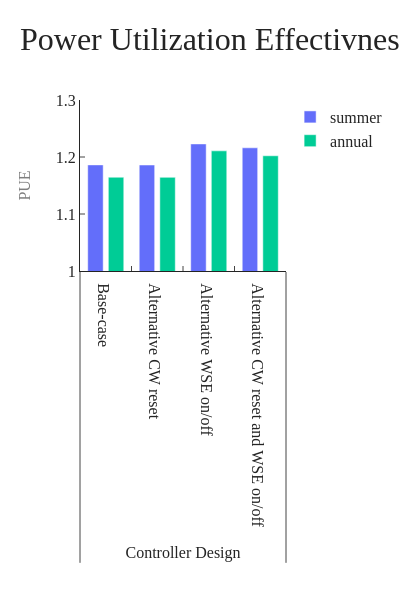

In [26]:
from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 400
height = 600

title = "Power Utilization Effectivness"


fig = go.Figure()

fig.update_layout(
    template="simple_white",
#         xaxis=dict(title_text="Simulator, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
    barmode="group",
    font=dict(family=font['family'], size=font['size']),
    title=title,
    titlefont=dict(size=font['size'] * 2.0, family=font['family']),
    xaxis=dict(
        title_text="",
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    yaxis=dict(
        title_text="PUE",
        range=[1,1.3],
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    showlegend=True,
    width=width,
    height=height,
#         margin=dict(l=margin_l, b=margin_b),
    legend=dict(
#             x=legend_x,
#             y=legend_y,
        font=dict(family=font['family'], size=font['size']),
    ),
)


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
colors = ['#636EFA', '#00CC96', '#AB63FA']

# to plot both simulators side by side use 'pue_only' directly 
# in the zip below
pue_single_simulator = pue_only[pue_only["Simulator"] == "dymola"]
pue_single_simulator["Controller Design Label"] = "Controller Design"

for r, c in zip(pue_single_simulator["Season"].unique(), colors):
    plot_df = pue_single_simulator[
        pue_single_simulator["Season"] == r]
#     fig.add_trace(
#         go.Bar(x=[plot_df["Simulator"].apply(
#             lambda x: x.capitalize()), plot_df["Controller Design"].apply(
#               lambda x: x[:-8])], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
#     )
    fig.add_trace(
        go.Bar(x=[plot_df["Controller Design Label"], plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
    )


img_bytes = fig.to_image(format="png", engine="kaleido")

filename = "pue"

pio.write_image(fig, os.path.join("img", filename + ".png"))

pio.write_image(fig, os.path.join("img", filename + ".pdf"))

from IPython.display import Image
Image(img_bytes)

In [93]:
pue_only

,PUE,Simulator,Controller Design,Season
0,1.19,dymola,"Base-case, Summer",summer
1,1.19,dymola,"Alternative CW reset, Summer",summer
2,1.22,dymola,"Alternative WSE on/off, Summer",summer
3,1.22,dymola,"Alternative CW reset and WSE on/off, Summer",summer
4,1.16,dymola,"Base-case, Annual",annual
5,1.16,dymola,"Alternative CW reset, Annual",annual
6,1.21,dymola,"Alternative WSE on/off, Annual",annual
7,1.20,dymola,"Alternative CW reset and WSE on/off, Annual",annual
8,1.14,optimica,"Base-case, Summer",summer
9,1.13,optimica,"Alternative CW reset, Summer",summer


# Create plots against an independent variable

## Example to access timeseries results for each variable

In [94]:
# Look at some resulting variables
cases.get_list_of_case_names()
# res['optimica']['test_base'].varNames()
(t, P_agg) = res['dymola']['base_summer'].values("QRooIntGaiAgg.y")
P_agg[-1]

4060800000000.0

## Configure plots

In [95]:
plt.rcParams['axes.facecolor']='whitesmoke'
plt.rcParams['font.size'] = 6
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.75
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

def save_plot(figure, file_name):
    """ Save the figure to a pdf and png file in the directory `img`
    """
    import os
    import matplotlib.pyplot as plt
    
    out_dir = "img"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    figure.savefig(os.path.join(out_dir, '{}.pdf'.format(file_name)))
    figure.savefig(os.path.join(out_dir, '{}.png'.format(file_name)))
    plt.clf()
    

def configure_axes(axes):
    """ Configure the axis style
    """
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.grid(color='lightgrey', linewidth=0.25)
    return


# ---------------------------------------------------------------------------
# helper functions and scripts

def set_cases_and_initiate_plot():
    from matplotlib.gridspec import GridSpec
    cases = ['test_base', 'test_1711']
    seasons = ['']
    num_cases = len(cases)
    num_seasons = len(seasons)
    
    fig = plt.figure(figsize=(6.5,8.))
    gs1 = GridSpec(80, 1)
    gs1.update(left=0.1, right=0.9, hspace=0.05)
    
    ax = list()
    ax.insert(0, fig.add_subplot(gs1[0:11,:]))
    ax.insert(1, fig.add_subplot(gs1[12:23,:]))
    ax.insert(2, fig.add_subplot(gs1[28:39,:]))
    ax.insert(3, fig.add_subplot(gs1[40:51,:]))
    ax.insert(4, fig.add_subplot(gs1[56:67,:]))
    ax.insert(5, fig.add_subplot(gs1[68:79,:]))
    
    # fig, ax = plt.subplots(nrows=num_cases*num_seasons, ncols=1, figsize = (6.5,8.))
    # fig, ax = plt.subplots(nrows=20, ncols=1, figsize = (6.5,8.))
    
    return cases, seasons, num_cases, num_seasons, fig, ax

def set_title(ax, title):
    left, width = .01, .97
    bottom, height = .01, .88
    right = left + width
    top = bottom + height
    
    title_str = r"$\it{" + title + "}$"
    ax.text(left, top,
            title_str,
            verticalalignment = 'center',
            horizontalalignment = 'left', 
            transform=ax.transAxes,
            fontsize = 6, color = 'k',
            bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    
def set_up_labels(i, ax, cases, seasons, num_cases, num_seasons, x_axis_label, y_axis_label):
    # Hide xtick labels and ticks on the upper case subplot (each basecase)
    if i % 2 == 0:
        hide_tick_labels(ax)

    # Print x axis title only below the lowest subplot
    if i  == num_cases*num_seasons - 1:
        ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))
     
    # Annotate case
    set_title(ax, cases[i % 2])
    # Annotate case
    # if i % 2 == 0:
    #     title_str = r"$\bf{" + seasons[i/2] + "}$" + ' (upper: ' + r"$\it{" + cases[i % 2] + "}$" + ', lower: ' + r"$\it{"  + cases[(i-1) % 2] + "}$" + ')'
    #     ax.set_title(title_str, # mg assign appropriate season/case
    #                  verticalalignment = 'top',
    #                  horizontalalignment = 'center', 
    #                  fontsize = 6, color = 'k')
        
    # Print legend only at the lower plot (g36 case)
    if i % 1 == 0:
        ax.legend(loc='center right', ncol=1)
    configure_axes(ax)
        
    #plt.tight_layout(h_pad=0)
    plt.tight_layout()
    #plt.subplots_adjust(hspace = .2)
        
def tem_conv_CtoF(T_in_degC):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degF = (T_in_degC)*9./5. + 32.
    
    return T_in_degF

def tem_conv_KtoC(T_in_K):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degC = T_in_K - 273.15
    
    return T_in_degC
        
def add_secondary_yaxis_for_degF(ax, time, temp_in_K):
        # Add a secondary axis with temperatures represented in F
        ax_F = ax.twinx()
        # Get limits to match with the left axis
        ax_F.set_ylim([tem_conv_CtoF(ax.get_ylim()[0]),tem_conv_CtoF(ax.get_ylim()[1])])
        # plot a "scaler" variable and make it invisible
        ax_F.plot(time, tem_conv_CtoF(temp_in_K-273.15), linewidth=0.0)
        ax_F.set_ylabel('temperature [$^\circ$F]')
        configure_axes(ax_F)
        #ax.grid(False)
        #ax.xaxis.grid()
        
def hide_tick_labels(ax):
    '''Removes labels and ticks. Kwargs: bottom controls the ticks, labelbottom the tick labels
    '''
    ax.tick_params(axis = 'x',labelbottom='off',bottom='off')

In [96]:
from pdb import set_trace as bp

# for a list of variables, using subplots

def plot_vs_independent_variable(
    res_set,
    var_names, 
    ind_var_name = "weaBus.TWetBul", 
    var_legend_labels = [['$test1$', '$test2$'], ['$test3$']], 
    subplot_x_labels = ["subpl 1", "subpl 2"]):
    ''' Plots a scatter of the variables selected in var_names
    against a provided independent variable, ind_var.
    
    Parameters:
    
        res_set : list or one reader object
            List of reader objects with case results, 
            index represents subplot, or one reader
            for all data
     
        var_names : list of lists
            A list of lists of variable names as provided by the reader, 
            for each subplot
            
        ind_var : str
            Name of the independent variable
            
        var_legend_labels : list of lists
            A list of lists for each subplot
            
        subplot_x_labels : list
            A list of x axis labels for each subplot
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 10}
    
    matplotlib.rc('font', **font)

    n_col = len(var_names)
        
    plt.clf()
    
    if not isinstance(res_set, list):
        res_set = np.repeat(res_set,n_col)
        
    elif not len(res_set) == n_col:
        raise Exception(
            'res_set size mismatch, it should be a list of '\
            'reader objects or a single reader object')
        

    # set the independent variable here, will be taken from the first
    # set or results
    
    ind_var = dict()
    for i in range(n_col):
        (t, ind_var[i]) = res_set[i].values(ind_var_name)
    
        if ".T" in ind_var_name:
            ind_var[i] = tem_conv_KtoC(ind_var[i])
    
    # subplot index
    i = 1
    
    ax = dict()
    
    fig = plt.figure(figsize=(15, 5))
    
    for subplot_var_names in var_names:
        
        v = dict()
        lbl = dict()

        j = 0
        for var in subplot_var_names:

            (t, v[var]) = res_set[i-1].values(var)
            lbl[var] = var_legend_labels[i-1][j]
            
            if ".T" in var:
                v[var] = tem_conv_KtoC(v[var])
                
            j += 1

        # create subplot
        
        ax[i] = fig.add_subplot(1, n_col, i)
        
        for key in v.keys():
            print(lbl[key])
            ax[i].scatter(v[key], ind_var[i-1], label = lbl[key], 
                linewidth=0.5, s = 1.)
            
            ax[i].legend(loc='center right', ncol=1)

        hide_tick_labels(ax[i])

        ax[i].set_xlabel(subplot_x_labels[i - 1])
    
        if i == 1:
            ax[i].set_ylabel('Outdoor air wetbulb temperature [$^\circ$C]')
        
        configure_axes(ax[i])
        
        i += 1
        
        del v
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    
    
    del ind_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], [["pumCHW.dp_in", "TAirSup.T"], ["pumCHW.m_flow"]], 
                                   var_legend_labels = [["CHW pump dif. pressure", "Air supply temperature"], ["CHW pump flow"]])
save_plot(fig, "test_many")


fig = plot_vs_independent_variable(res["dymola"]["1711_cwreset_annual"], [["TChiWatSupSen.T"], ["TConWatRetSen.T"]], 
                                   var_legend_labels = [["CHW loop temperature [$^\circ$C]"],["CW loop temperature [$^\circ$C]"]])
save_plot(fig, "CWreset_loop_temps")

fig = plot_vs_independent_variable([res["dymola"]["base_annual"],res["dymola"]["1711_wse_annual"]], 
                                   [["waterSideEconomizerOnOff.yOn"], ["yWSEOn.y"]], 
                                   subplot_x_labels = ["base_annual", "1711_wse_annual"],
                                   var_legend_labels = [["WSE on/off signal"],["WSE on/off signal"]])
save_plot(fig, "WSE_on_vs_outdoor_wetbulb")

CHW pump dif. pressure
Air supply temperature
CHW pump flow
CHW loop temperature [$^\circ$C]
CW loop temperature [$^\circ$C]
WSE on/off signal
WSE on/off signal


In [97]:
from pdb import set_trace as bp

# works for one variable

def plot_vs_independent_variable(
    res_set,
    x_var_name, 
    ind_var_name = "weaBus.TWetBul",
    var_legend_label = 'legend label',
    x_label = "x label",
    y_label = "Outdoor air wetbulb temperature [$^\circ$C]"):
    
    ''' Plots a scatter of x_var_name
    against a provided ind_var_name.
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set an independent variable here
    (t, y_var) = res_set.values(ind_var_name)
    (t, x_var) = res_set.values(x_var_name)
    
    if ".T" in ind_var_name:
        y_var = tem_conv_KtoC(y_var)
        
    if ".T" in x_var_name:
        x_var = tem_conv_KtoC(x_var)

    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = var_legend_label, 
        linewidth=0.5, s = 1.)

    hide_tick_labels(ax)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
    
    del y_var, x_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "pumCHW.dp_in", "weaBus.TWetBul", x_label = "CHW loop differential pressure [Pa]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "test_one_var_vs_indep")

fig = plot_vs_independent_variable(res["dymola"]["1711_cwreset_annual"], "TChiWatSupSen.T", "weaBus.TWetBul", x_label = "CHW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "chw_temp_vs_wetbulb")

fig = plot_vs_independent_variable(res["dymola"]["1711_cwreset_annual"], "TConWatRetSen.T", "weaBus.TWetBul", x_label = "CW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "cw_temp_vs_wetbulb")

In [98]:
var_legend_labels = [['$test1$', '$test2$'], '$test3$']
var_legend_labels[1,1]

TypeError: list indices must be integers or slices, not tuple

# Control diagrams through simulation

In [100]:
def plot_control_diagram(
    res_set,
    y_var_name,
    sec_y_var_name,
    x_var_name = "weaBus.TWetBul",
    x_legend_label = 'x legend label',
    y_legend_label = 'y legend label',
    x_label = "x label",
    y_label = "y label",
    sec_y_label = "sec y label",
    ):
    
    ''' 
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set variables
    (t, x_var) = res_set.values(x_var_name)
    (t, y_var) = res_set.values(y_var_name)
    (t, sec_y_var) = res_set.values(sec_y_var_name)
    
    if ".T" in y_var_name:
        y_var = tem_conv_KtoC(y_var)
    
    if ".T" in sec_y_var_name:
        sec_y_var = tem_conv_KtoC(sec_y_var)

    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = x_legend_label, 
        linewidth=0.5, s = 1.)
    
    ax_2 = ax.twinx()
    # plot a "scaler" variable and make it invisible
    ax_2.scatter(x_var, sec_y_var,  
              label = y_legend_label, linewidth=0.5, s = 1.)

    hide_tick_labels(ax)
    hide_tick_labels(ax_2)
    
    configure_axes(ax)
    configure_axes(ax_2)
    
    ax_2.set_ylabel(sec_y_label)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
#     ax.legend(loc='center right', ncol=1)
    
    del y_var, sec_y_var
        
    return plt


fig = plot_control_diagram(res["dymola"]["base_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW loop differential pressure [Pa]",
    sec_y_label = "CHW loop temperature [$^\circ$C]")

save_plot(fig, "base_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["1711_cwreset_wse_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW loop differential pressure [Pa]",
    sec_y_label = "CHW loop temperature [$^\circ$C]")

save_plot(fig, "1711_cwreset_wse_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["1711_cwreset_wse_annual"], 
    "heaPreCon.yMaxTowSpeSet", "heaPreCon.yConWatPumSpeSet", x_var_name = "heaPreCon.chiHeaPreLoo.yHeaPreCon",
    x_label = "CW reset control signal",
    y_label = "Cooling tower fan speed",
    sec_y_label = "CW pump speed")

# save_plot(fig, "1711_cwreset_wse_annual_control_diagram")
save_plot(fig, "1711_cwreset_wse_annual_cw_reset_control_diagram")

In [ ]:
# res["dymola"]["1711_cwreset_annual"].varNames()
#  (t, sec_y_var) = res["dymola"]["1711_cwreset_annual"].values("chilledWaterReset.TChiWatSupSet")
sec_y_var

# Timeseries plots

## Chiller plant - power

*mg adjust this method to take various cases as needed

In [ ]:
def plot_power(res_set):
    ''' Main method that plots the results
    '''
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
       
    (t, pumCHW_P) = res_set.values("pumCHW.P")
    (t, pumCW_P) = res_set.values("pumCW.P")
    (t, chi_P) = res_set.values("chi.P")
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, pumCHW_P, label = '$P_{chw,p}$', linewidth=0.5)
         
    # make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('Chiller water pump power [W]')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), min(t)+24])
    ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_power(res["dymola"]["base_annual"])
save_plot(fig, "CHWpum_P")

In [ ]:
res['optimica'].keys()

## Outside conditions

In [ ]:
def plot_outside(res_set):
    # ------------------------------------------------------
    plt.clf()
    plt.ylim([0., 20.])
    time_scale=86400.
    # ------------------------------------------------------
    
    ax = list()
    # get a list of unique climate cases
    unique_climate_cases = list(res_set.keys())[0] # all in the same climate
    
    subplot_id = 0
    for climate in unique_climate_cases:
        (t, TOut) = res_set[case_name].values("weaBus.TDryBul")
        (t, TOutWet) = res_set[case_name].values("weaBus.TWetBul")
        
        t = t/time_scale
        
        # Generate figure and plot data
        ax.insert(subplot_id, plt.subplot(len(unique_climate_cases)*2, 1, subplot_id+1))
        
        for subplot_id in [0,2,4]:
            ax[subplot_id].plot(t, TOut-273.15, 'r', \
                   label='$T_{oa}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOut)
            set_title(ax[subplot_id], '$T_{oa}$')
        
        subplot_id += 1
        
        for subplot_id in [1,3,5]:
            ax[subplot_id].plot(t, TOutWet-273.15, 'r', \
                   label='$T_{oa,w}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOutWet)
            set_title(ax[subplot_id], '$T_{oa,w}$')
        
        # customize days to display
        ax[subplot_id].set_xlim([min(t)+5, min(t)+10])

        configure_axes(ax[subplot_id])
        ax[subplot_id].legend(loc='center right', ncol=1)
        
        subplot_id += 1

#     ax[5].set_xlabel('time [days]')

    return plt

# Create the plot for all seasons and cases
fig = plot_outside(res["dymola"])
save_plot(fig, "outside")

cases.get_list_of_case_names()
